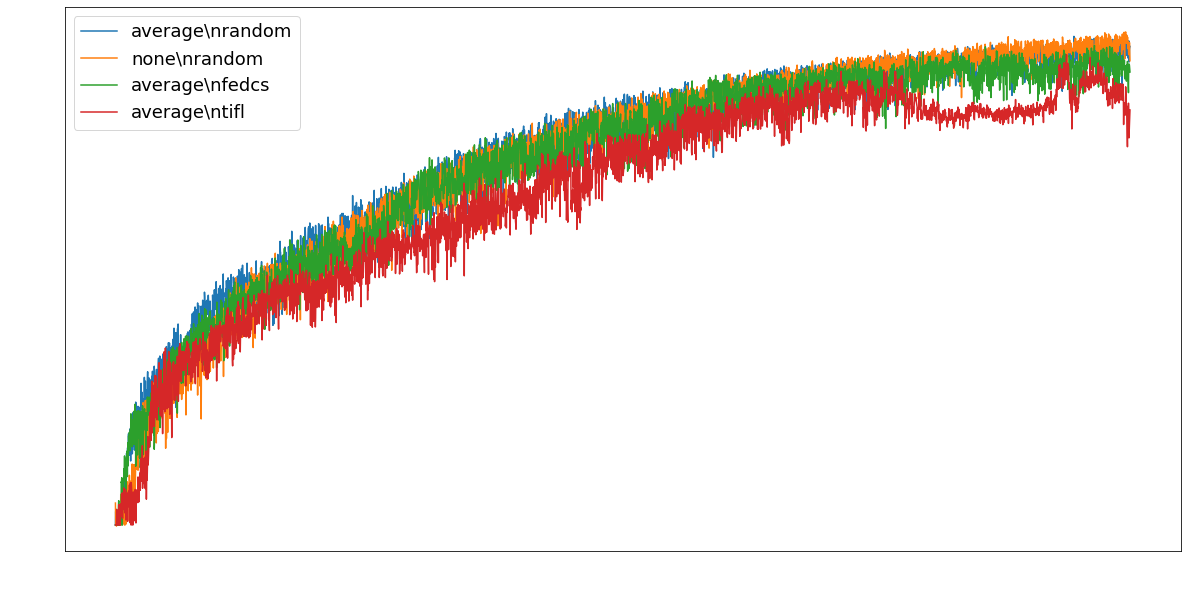

,averagefedcs,averagerandom,averagetifl,nonerandom
finish_time,345730.541218,574212.771862,344945.218281,0.000000
mean_acc,0.716559,0.737179,0.674189,0.747218
std_acc,0.014339,0.011519,0.017547,0.010266
avg_failed,0.249000,0.360000,0.247750,0.000000
rounds_failed,889.000000,1242.000000,878.000000,0.000000
unique_participants,68.000000,100.000000,100.000000,100.000000


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import re
import os
import pandas as pd
import ast
from IPython.display import display, HTML
from io import StringIO

plt.rcParams.update({
    'font.size': 18,
    'text.color': 'black',
    'axes.labelcolor': 'white',
    'xtick.color': 'white',
    'ytick.color': 'white'
})
plt.figure(figsize=(20, 10))

data = {}


def extract_file_data(file):
    with open(file) as file:
        raw = file.read()
        failed = re.compile('Round \d+ failed clients: (\[[^]]*])').findall(raw)
        failed = map(lambda x: x if ',' in x else ', '.join(x.split()).replace('[,', '[').replace(',]', ']'), failed)
        failed = list(map(len, map(ast.literal_eval, failed)))
        avg_failed = np.mean(failed)
        rounds_failed = len(list(filter(lambda x: x > 0, failed)))
        selected = re.compile('Sampled clients for round \d+: (\[[^]]*])').findall(raw)
        selected = map(lambda x: x if ',' in x else ', '.join(x.split()).replace('[,', '[').replace(',]', ']'), selected)
        selected = list(map(ast.literal_eval, selected))
        unique_participants = len(set().union(*selected))
        return avg_failed, unique_participants, rounds_failed


base = 'results/cifar/'


def extract_config(raw, key):
    if key in raw:
        return re.compile(key + '\s+=\s+(\S+)').search(raw).group(1)
    return ''


for dir in os.listdir(base):
    config = ''
    with open(base + dir + '/args.txt') as args:
        args = args.read()
        config = extract_config(args, 'trace_distro')
        mode = extract_config(args, 'time_mode')
        if mode == 'none':
            config = mode
        config += '\\n' + extract_config(args, 'selector')
        if 'mda' in config or 'tiflx' in config:
            config += '-' + extract_config(args, 'mda_method')
            config += '-' + extract_config(args, 'score_method')

    accuracies = np.load(base + dir + '/accuracies.npy')
    for file in os.listdir(base + dir):
        if file.endswith('.out'):
            avg_failed, unique_participants, rounds_failed = extract_file_data(base + dir + '/' + file)

    plt.plot(range(len(accuracies)), accuracies, label=config)
    times = np.load(base + dir + '/times.npy')
    data[config] = {
        'finish_time': times[-1],
        'mean_acc': accuracies[-100:].mean(),
        'std_acc': accuracies[-100:].std(),
        'avg_failed': avg_failed,
        'rounds_failed': rounds_failed,
        'unique_participants': unique_participants
    }

plt.xlabel('Round number')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

df = pd.DataFrame(data)
df = df.sort_index(axis=1)
display(HTML(df.to_html().replace("\\n", "<br>")))